For this tutorial the following packages are required in addition to the `simframe` requirements:

* `matplotlib`

In this tutorial you'll learn how to set up and use adaptive integration schemes.

# Adaptive Integration Schemes

Consider the setup of the first example. But this time we increase the step size, such that the numeric solution is oscillating around the exact solution.

### Problem parameters

In [1]:
dx = 1.75
A  = 1.
b  = -1.

### Setting up frame

In [2]:
from simframe import Frame

sim = Frame(description="Adaptive step sizing")

### Adding field and integration variable.

In [3]:
sim.addintegrationvariable("x", 0.)
sim.addfield("Y", A)

In [4]:
### Setting up writer

In [5]:
from simframe import writers

In [6]:
sim.writer = writers.hdf5writer
sim.writer.overwrite = True
sim.writer.datadir = "5_data"

### Setting differential equation.

We want to count how often the derivative gets called in this problem. Therefore we set a global variable `N`, that is incremented ever time the is called.

In [7]:
N = 0

In [8]:
def dYdx(sim, x, Y):
    global N
    N += 1
    return b*Y

In [9]:
sim.Y.differentiator = dYdx

### Setting up step size

Here we return a constant step size defined in the beginning.

In [10]:
def fdx(sim):
    return dx

In [11]:
sim.x.updater = fdx

### Setting up snapshots

In [12]:
import numpy as np
sim.x.snapshots = np.arange(dx, 15., dx)

### Setting up integrator

As in the first example we use the simple Euler 1st-order integration scheme.

In [13]:
from simframe import Integrator
from simframe import Instruction
from simframe import schemes

In [14]:
sim.integrator = Integrator(sim.x)

In [15]:
sim.integrator.instructions = [Instruction(schemes.expl_1_euler, sim.Y)]

### Running the simulation

In [16]:
sim.run()

Creating data directory '5_data'.
Writing file '5_data/data0000.hdf5'
Writing file '5_data/data0001.hdf5'
Writing file '5_data/data0002.hdf5'
Writing file '5_data/data0003.hdf5'
Writing file '5_data/data0004.hdf5'
Writing file '5_data/data0005.hdf5'
Writing file '5_data/data0006.hdf5'
Writing file '5_data/data0007.hdf5'
Writing file '5_data/data0008.hdf5'


### Reading data

In [17]:
data = sim.writer.read.all()

In [18]:
dataset = []
dataset.append([data, "Euler 1st-order", N])

### Plotting

Function returning the exact solution used for plotting

In [19]:
def f(x):
    return A*np.exp(b*x)

In [20]:
import matplotlib.pyplot as plt

def plot(dataset):
    fig, ax = plt.subplots(dpi=300)
    x = np.linspace(0, 15., 100)
    ax.plot(x, f(x), c="black", label="Exact solution")
    for i, val in enumerate(dataset):
        ax.plot(val[0].x, val[0].Y, "o", c="C"+str(i), label="{} ({} evaluations)".format(val[1], val[2]))
        ax.plot(val[0].x, val[0].Y, c="C"+str(i), lw=1)
    ax.legend(fontsize="small")
    fig.tight_layout()

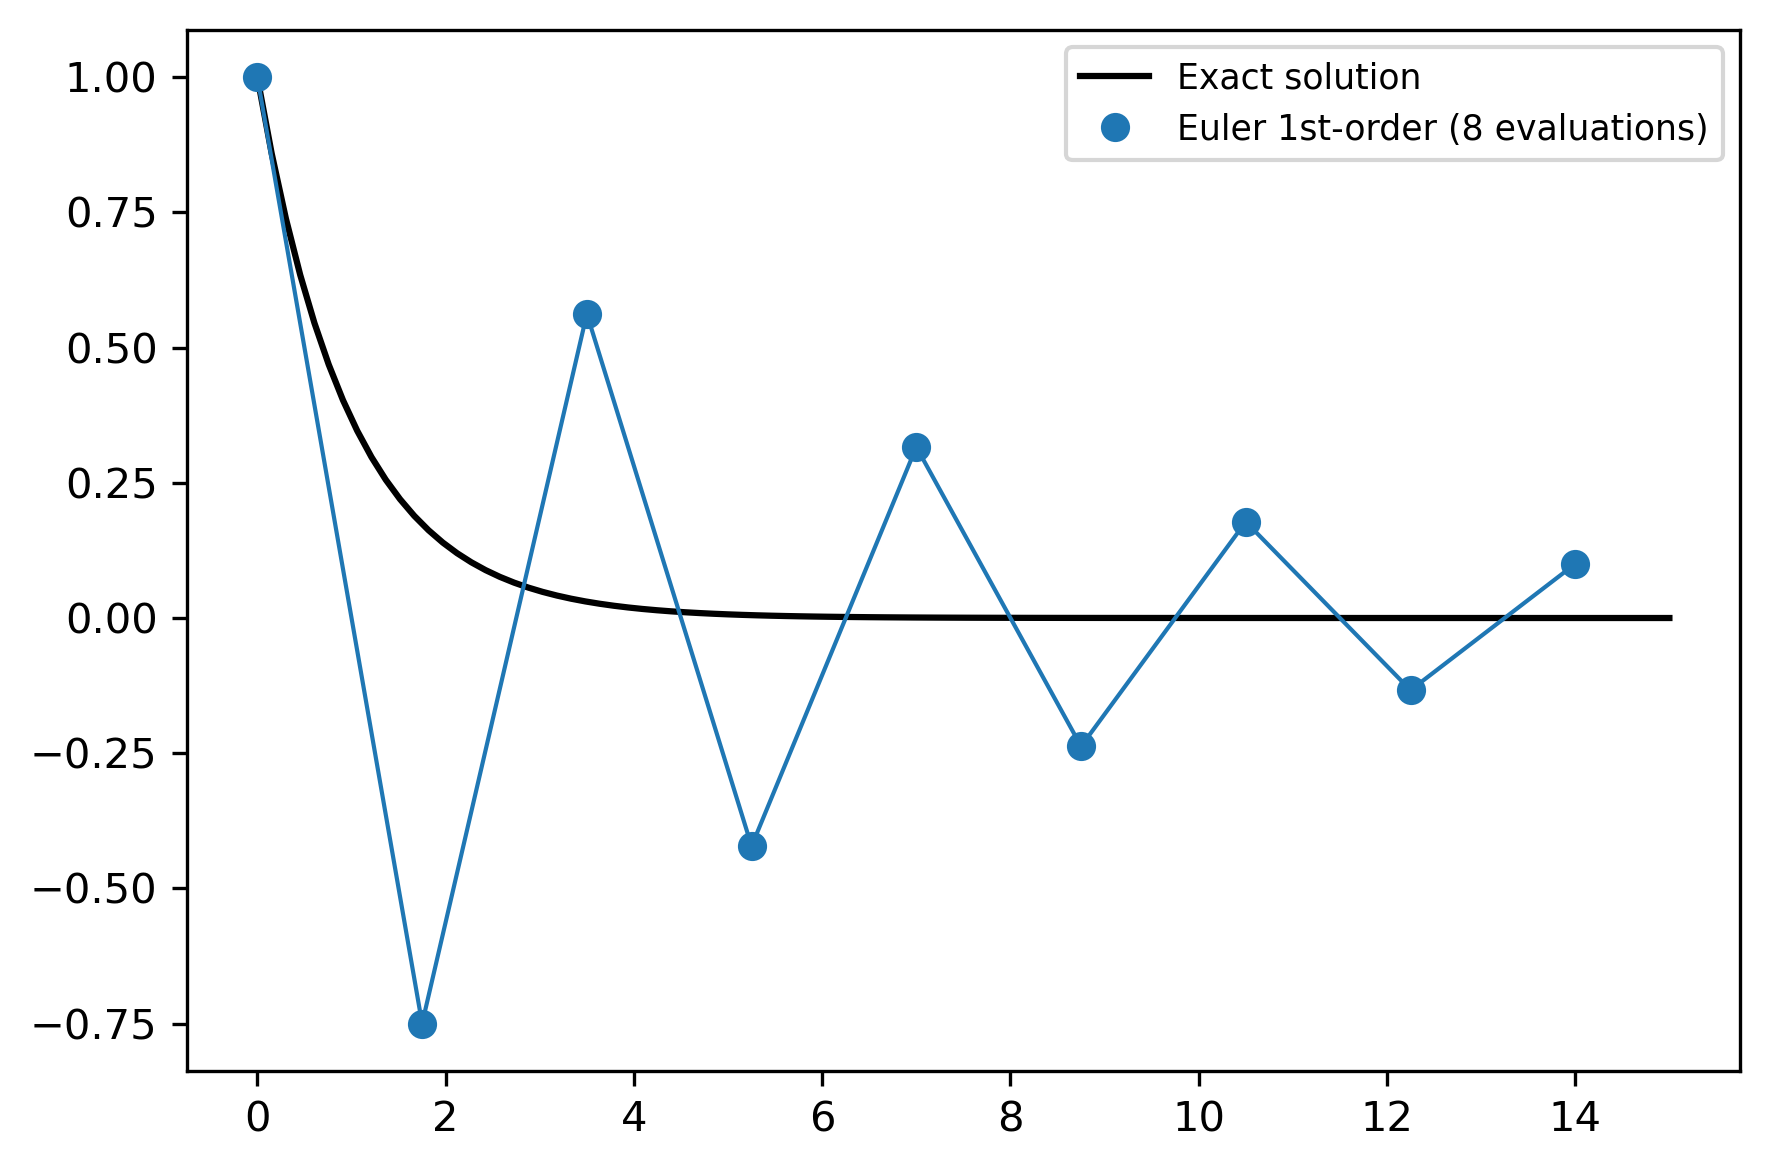

In [21]:
plot(dataset)

As you can see, the calculated solution is scillating aroung the real solution.

## Adaptive Step Sizing

Instead of a constant step size, we now want to adjust it dynamically. If the error is too large, we decrease the step size. As an estimate for the error we compare the full Euler 1st-order step to the solution we get from performing two consecutive Euler 1st-order step with half the step size. If the relative error is larger than 10 %, we repeat the integration with a small step size until we are withing the error.

We therefore have to set up a custom integration scheme as was shown in the previous example. The scheme has to perform the full step, two semi steps, and needs to compare them. If the error is too large, the scheme has to return `False`. If it was successful, if has to return the change in our dependent variable `Y`.

In [23]:
def adaptive(x0, Y0, dx, *args, **kwargs):
    fullstep  = dx*Y0.derivative(x0, Y0)
    semistep1 = 0.5*fullstep
    semistep2 = 0.5*dx*Y0.derivative(x0+0.5*dx, Y0+semistep1)
    semisteps = semistep1 + semistep2
    
    relerr = np.abs((semisteps-fullstep)/(Y0+semisteps))
    
    if relerr > 0.1:
        return False
    else:
        return semisteps

### Creating scheme and modifying instruction set

In [24]:
from simframe.integration import AbstractScheme

In [25]:
adaptive = AbstractScheme(adaptive)

In [26]:
sim.integrator.instructions = [Instruction(adaptive, sim.Y)]

If the integration failed, because the step size was too large, i.e., the scheme returned `False`, the integrator triggers a fail operation. This operation can be used to manipulate the step size. In our case, we want to decrease the step size by a factor of 10. If the integration was successful, we want to increase the step size by a factor of 5.

Note the `global dx` to manipule `dx` persistently outside the function.

In [27]:
def failop(sim):
    global dx
    dx /= 10.

We assign this function to the fail operation of the integrator. The fail operation needs the parent `Frame` object as positional argument. If any instruction returns `False`, the fail operation will be executed and the integrator goes through the instructions again, before updating the fields.

Note: In case you have an `update` instuction in your instruction set, you have to undo it by yourself in the fail operation.

In [28]:
sim.integrator.failop = failop

If the integration was successful, we want to increase our step size by a factor of 5. This is done via the `finalization` of the integrator, which is called after going through the instruction set and after updating the fields to be integrated. The equivalent that is called before going through the instructions set is `<Frame>.integrator.preparation`.

In [29]:
def finalize(sim):
    global dx
    dx *= 5.

In [30]:
sim.integrator.finalization = finalize

### Resetting the parameters

In [31]:
N = 0
sim.x = 0.
sim.Y = 1.
sim.writer.datadir = "5_data_adaptive"

Before running the simulation we save the inital step size for later use.

In [32]:
dx_ini = dx

### Running the simulation

In [33]:
sim.run()

Creating data directory '5_data_adaptive'.
Writing file '5_data_adaptive/data0000.hdf5'
Writing file '5_data_adaptive/data0001.hdf5'
Writing file '5_data_adaptive/data0002.hdf5'
Writing file '5_data_adaptive/data0003.hdf5'
Writing file '5_data_adaptive/data0004.hdf5'
Writing file '5_data_adaptive/data0005.hdf5'
Writing file '5_data_adaptive/data0006.hdf5'
Writing file '5_data_adaptive/data0007.hdf5'
Writing file '5_data_adaptive/data0008.hdf5'


### Reading data and plotting

In [34]:
data_adaptive = sim.writer.read.all()

In [35]:
dataset.append([data_adaptive, "Adaptive Euler 1st-order", N])

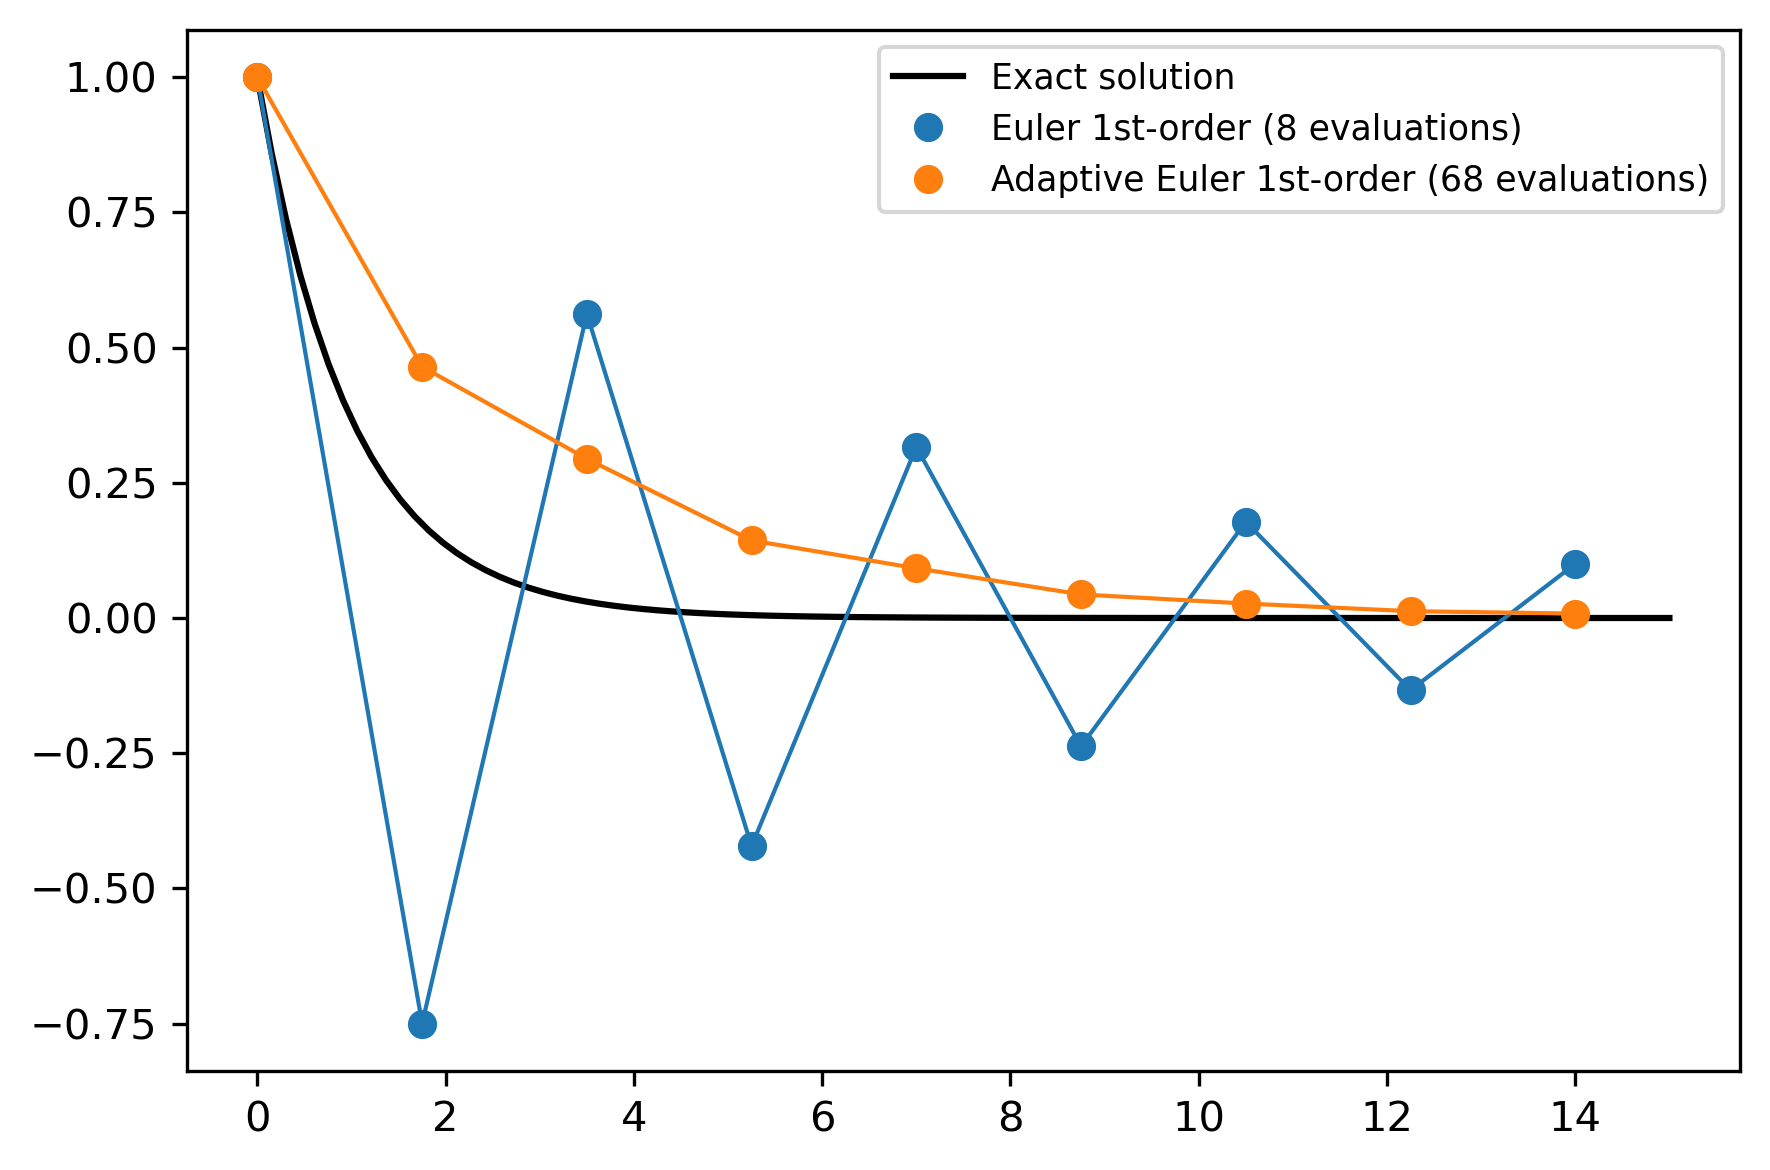

In [36]:
plot(dataset)

## Embedded methods

Another technique for estimating the error is to perform a higher order method for the full step instead of the same method for two semistep as done before. In some cases the higher order method is utilizing the result of the lower order method, saving evaluations. These methods are called embedded methods.

`simframe` comes with a few embedded methods. In this example we use the embedded Euler-Heun method.

In [37]:
sim.integrator.instructions = [Instruction(schemes.expl_2_heun_euler_adptv, sim.Y)]

### Unsetting fail operation and finalization

In [38]:
sim.integrator.failop = None
sim.integrator.finalization = None

The embedded methods included in `simframe` provide an estimate for the new step size depending on the truncation error. This estimate is saved in the integration variable in `<IntVar>.suggested`. We have to modify the step size function to utilize this estimate.

In [39]:
def fdx(sim):
    return sim.x.suggested

In [40]:
sim.x.updater = fdx

And we have to give an initial suggestion for the step size. We'll use the initial value as before.

In [41]:
sim.x.suggest(dx_ini)

### Resetting the parameters and running the simulation

In [42]:
N = 0
sim.x = 0.
sim.Y = 1.
sim.writer.datadir = "5_data_heuneuler"

In [43]:
sim.run()

Creating data directory '5_data_heuneuler'.
Writing file '5_data_heuneuler/data0000.hdf5'
Writing file '5_data_heuneuler/data0001.hdf5'
Writing file '5_data_heuneuler/data0002.hdf5'
Writing file '5_data_heuneuler/data0003.hdf5'
Writing file '5_data_heuneuler/data0004.hdf5'
Writing file '5_data_heuneuler/data0005.hdf5'
Writing file '5_data_heuneuler/data0006.hdf5'
Writing file '5_data_heuneuler/data0007.hdf5'
Writing file '5_data_heuneuler/data0008.hdf5'


### Reading data and plotting

In [44]:
data_heuneuler = sim.writer.read.all()

In [45]:
dataset.append([data_heuneuler, "Adaptive Heun-Euler 2nd-order", N])

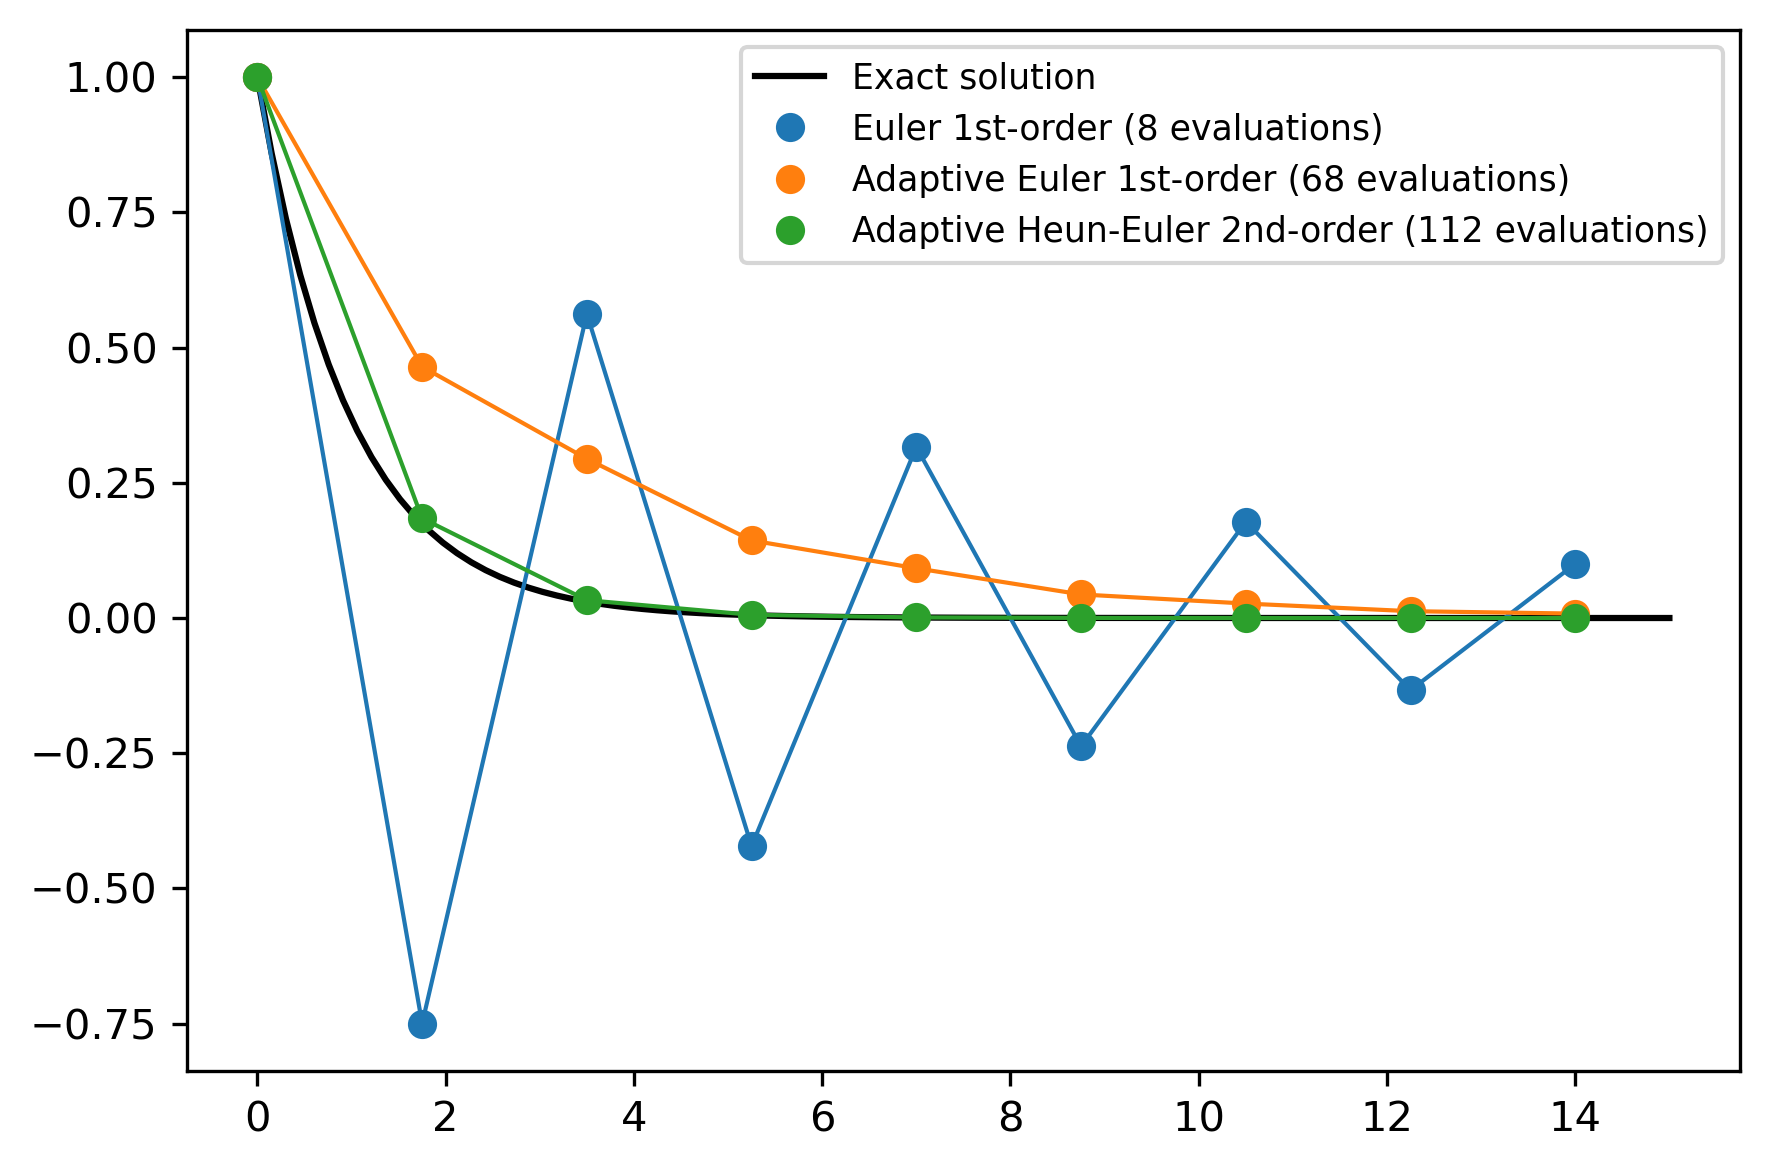

In [46]:
plot(dataset)

As you can see the Heun-Euler method needs 96 eveluations of the derivative in this setup. That's 1.4 the amount of evaluation compared to the adaptive Euler method, but it's significantly more accurate.

Change the stepsize to `dx = 2.25` and run the notebook again. For this step size the Euler 1st-order method is unstable. You have to delete the data directories first.